In [11]:
!pip install Quandl

In [12]:
import quandl as Quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection as cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import datetime



In [13]:
style.use('ggplot')

#Use Pandas to populate the data frame
df = Quandl.get("WIKI/AMZN",api_key='tJbUksb_TeZXtwAgDeia')
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
print(df.head(5))

            Adj. Open  Adj. High  Adj. Low  Adj. Close  Adj. Volume
Date                                                               
1997-05-16   1.865000   1.979167  1.708333    1.729167   14700000.0
1997-05-19   1.708333   1.770833  1.625000    1.708333    6106800.0
1997-05-20   1.729167   1.750000  1.635833    1.635833    5467200.0
1997-05-21   1.604167   1.645833  1.375000    1.427500   18853200.0
1997-05-22   1.437500   1.448333  1.312500    1.395833   11776800.0


In [14]:
#Calculate percentages
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Low'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0


#Predict closing values
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
forecast_col = 'Adj. Close'

print(df.head(5))




            Adj. Close     HL_PCT  PCT_change  Adj. Volume
Date                                                      
1997-05-16    1.729167  15.853659   -7.283289   14700000.0
1997-05-19    1.708333   8.974359    0.000000    6106800.0
1997-05-20    1.635833   6.979114   -5.397590    5467200.0
1997-05-21    1.427500  19.696970  -11.012987   18853200.0
1997-05-22    1.395833  10.349206   -2.898551   11776800.0


In [15]:
#Replace any NAN so that data is not lost
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

# X is the input data and excludes labels to be predicted
X = np.array(df.drop(['label'], 1))
#Preprocessing gets values between -1 and 1
X = preprocessing.scale(X)
#Input for which prediction is needed
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)

#Output to be predicted
y = np.array(df['label'])
print(y[:5])


[2.41666667 2.3125     2.20833333 2.25       2.1775    ]


In [16]:

#Use linear regression classifier
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print('Confidence:', confidence)

Confidence: 0.9763377658048307


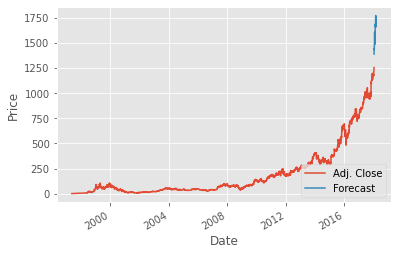

In [18]:
forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
#Plot the graph for visualizayion
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

#Store the model
import pickle
with open('linearregression.pickle','wb') as f:
    pickle.dump(clf, f)